In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Homework 3

## References

+ Lectures 9 through 12 (inclusive).

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

## Student details

+ **First Name:** Rohan
+ **Last Name:** Dekate
+ **Email:** dekate@purdue.edu
+ **Used generative AI to complete this assignment (Yes/No):** No
+ **Which generative AI tool did you use (if applicable)?:** No

## Problem 1 - Implement autoencoders in `jax`, `equinox`, and `optax`

Implement [autoencoders](https://en.wikipedia.org/wiki/Autoencoder) in `jax` and train it on the MNIST dataset.
Autoencoders, consist of two neural networks, an encoder and a decoder. The encoder maps the input to a latent space (typically of a much smaller dimension than the input), and the decoder maps the latent space back to the input space.
You can think of the encoder as a compression algorithm and the decoder as a decompression algorithm.
Alternatively, you can think of the encoder as the projection of the input data onto a lower-dimensional manifold, and the decoder as the reconstruction operator.

Follow these directions:
+ Pick the dimension of the latent space to be 2. This means that the encoder will map the input to a 2-dimensional space, and the decoder will map the 2-dimensional space back to the input space.
+ Your encoder should work on a flattened version of the input image. This means that the input to the encoder is a vector of 784 elements (28x28).
+ Start by picking your encoder $z = f(x;\theta_f)$ to be a neural network with 2 hidden layers, each with 128 units and ReLU activations. Increase the number of units and layers if you think it is necessary.
+ Start by picking your decoder $x' = g(z;\theta_g)$ to be a neural network with 2 hidden layers, each with 128 units and ReLU activations. Increase the number of units and layers if you think it is necessary.
+ Make all your neural networks in `equinox`.
+ The loss function is the mean squared error between the input and the output of the decoder:

$$
\mathcal{L} = \frac{1}{N}\sum_{i=1}^N ||x_i - g(f(x_i;\theta_f);\theta_g)||^2.
$$

where $N$ is the number of samples in the dataset.
+ Split the MNIST dataset into a training and a test set.
+ Use `optax` for the optimization.
+ Train the autoencoder using the Adam optimizer with a learning rate of 0.001 for 1 epoch to debug. Use a batch size of 32. Feel free to play with the learning rate and batch size.
+ Monitor the loss function on the training and test set. Increase the number of epochs up to the point where the loss function on the test set stops decreasing.

Once you are done training, visualize the projections of the digits in the latent space. Don't bother drawing little images of the digits. Just plot the 2D points and label them with the digit they correspond to. You can use `matplotlib` for this.

Here is the dataset:

In [2]:
# Download the MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
import jax.numpy as jnp
import numpy as np

# Function to Convert to Numpy Array
def convert_to_jax_array(data):
    data = data.astype(np.float32)
    data = np.array(data)
    return data

In [4]:
X_train = convert_to_jax_array(X_train)
print(f"Type of X_train: {type(X_train)} with Shape:{X_train.shape}")
y_train = convert_to_jax_array(y_train)
print(f"Type of y_train: {type(y_train)} with Shape:{y_train.shape}")
X_val = convert_to_jax_array(X_val)
print(f"Type of X_val: {type(X_val)} with Shape:{X_val.shape}")
y_val = convert_to_jax_array(y_val)
print(f"Type of y_val: {type(y_val)} with Shape:{y_val.shape}")

Type of X_train: <class 'numpy.ndarray'> with Shape:(50000, 784)
Type of y_train: <class 'numpy.ndarray'> with Shape:(50000,)
Type of X_val: <class 'numpy.ndarray'> with Shape:(10000, 784)
Type of y_val: <class 'numpy.ndarray'> with Shape:(10000,)


In [5]:
# Scale the dataset
X_train_scaled = X_train/255.0
X_val_scaled = X_val/255.0

## Part A
*Put your answer here. Use as many markdown and code blocks as you want.*

In [6]:
!pip install equinox

In [7]:
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import equinox as eqx
import jax
import optax
from functools import partial
from jax import jit, grad

In [8]:
class Encoder(eqx.Module):
    encoder: list

    def __init__(self, key):
        k1,k2,k3,k4 = jax.random.split(key, 4)

        self.encoder = [
            eqx.nn.Linear(784, 512, key=k1),
            eqx.nn.Linear(512, 128, key=k2),
            eqx.nn.Linear(128, 64, key=k3),
            eqx.nn.Linear(64, 2, key=k4)
            ]

    @partial(jax.vmap, in_axes=(None, 0))
    def __call__(self, x):
        for layer in self.encoder[:-1]:
            x = jax.nn.relu(layer(x))
        x = self.encoder[-1](x)
        return x

class Decoder(eqx.Module):
    decoder: list

    def __init__(self, key):
        k1,k2,k3,k4 = jax.random.split(key, 4)

        self.decoder = [
            eqx.nn.Linear(2, 64, key=k1),
            eqx.nn.Linear(64, 128, key=k2),
            eqx.nn.Linear(128, 512, key=k3),
            eqx.nn.Linear(512, 784, key=k4)
            ]

    @partial(jax.vmap, in_axes=(None, 0))
    def __call__(self, x):
        for layer in self.decoder[:-1]:
            x = jax.nn.relu(layer(x))
        x = self.decoder[-1](x)
        return x

In [9]:
# The function below generates batches of data
def data_generator(X, batch_size, shuffle=True):
    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    if shuffle:
        np.random.shuffle(indices)

    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices]

# This is the loss function
def loss(model, x):
    encoder, decoder = model
    encoded = encoder(x)
    decoder = decoder(encoded)
    y_pred = decoder
    return optax.l2_loss(y_pred, x).mean()

# This is the training loop
def train_batch(
        model,
        x,
        optimizer,
        x_test,
        n_batch=10,
        n_epochs=10,
        freq=1,
    ):

    # This is the step of the optimizer. We **always** jit:
    @eqx.filter_jit
    def step(opt_state, model, xi):
        value, grads = eqx.filter_value_and_grad(loss)(model, xi)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value

    # The state of the optimizer
    opt_state = optimizer.init(model)
    # The path of the model
    path = []
    # The path of the test loss
    losses = []
    # The path of the test accuracy
    test_losses = []
    for e in range(n_epochs):
        for i, (xb) in enumerate(data_generator(x, n_batch)):
            model, opt_state, value = step(opt_state, model, xb)
            if i % freq == 0:
                path.append(model)
                losses.append(value)
                test_losses.append(loss(model, x_test))
                print(f"Epoch {e}, step {i}, loss {value:.3f}, test {test_losses[-1]:.3f}")
    return model, path, losses, test_losses

In [10]:
ENCODER = Encoder(jax.random.PRNGKey(1234))
DECODER = Decoder(jax.random.PRNGKey(5678))
MNIST_AutoEncoder = (ENCODER, DECODER)
# print(MNIST_AutoEncoder)

In [11]:
(encoder, decoder), path, losses, test_losses = train_batch(
    MNIST_AutoEncoder,
    X_train_scaled,
    optax.adam(0.001),
    X_val_scaled,
    n_batch=32,
    n_epochs=100,
    freq=1000,
)

Epoch 0, step 0, loss 0.055, test 0.054
Epoch 0, step 1000, loss 0.023, test 0.022
Epoch 1, step 0, loss 0.020, test 0.021
Epoch 1, step 1000, loss 0.023, test 0.020
Epoch 2, step 0, loss 0.018, test 0.020
Epoch 2, step 1000, loss 0.020, test 0.020
Epoch 3, step 0, loss 0.020, test 0.019
Epoch 3, step 1000, loss 0.019, test 0.019
Epoch 4, step 0, loss 0.021, test 0.019
Epoch 4, step 1000, loss 0.019, test 0.019
Epoch 5, step 0, loss 0.019, test 0.019
Epoch 5, step 1000, loss 0.019, test 0.019
Epoch 6, step 0, loss 0.018, test 0.019
Epoch 6, step 1000, loss 0.017, test 0.018
Epoch 7, step 0, loss 0.019, test 0.018
Epoch 7, step 1000, loss 0.020, test 0.018
Epoch 8, step 0, loss 0.017, test 0.018
Epoch 8, step 1000, loss 0.016, test 0.018
Epoch 9, step 0, loss 0.018, test 0.018
Epoch 9, step 1000, loss 0.019, test 0.018
Epoch 10, step 0, loss 0.019, test 0.018
Epoch 10, step 1000, loss 0.019, test 0.018
Epoch 11, step 0, loss 0.017, test 0.018
Epoch 11, step 1000, loss 0.018, test 0.018


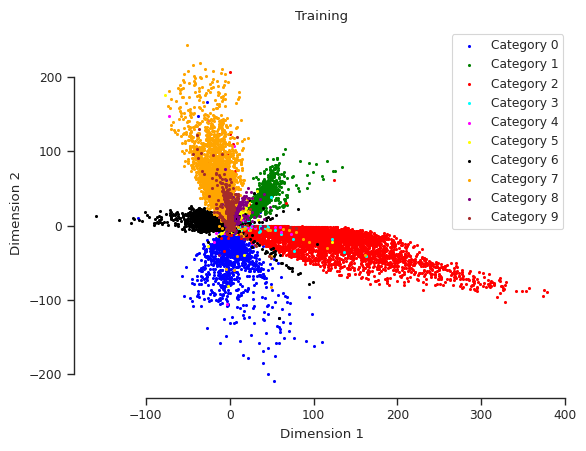

In [12]:
encoder_pred_train = encoder(X_train_scaled)
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']
fig, ax = plt.subplots()
for i in range(10):
    ax.scatter(encoder_pred_train[:, 0][y_train == i], encoder_pred_train[:, 1][y_train == i],
                color=colors[i], label=f'Category {i}', s=2)

ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_title("Training")
ax.legend(loc="best")
sns.despine(trim=True)

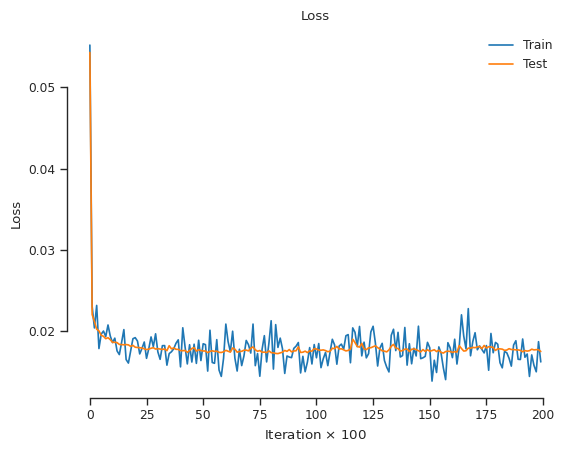

In [13]:
fig, ax = plt.subplots()
ax.plot(losses, label="Train")
ax.plot(test_losses, label="Test")
ax.set(xlabel="Iteration $\\times$ 100", ylabel="Loss", title="Loss")
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Part B

Pick the first five digits in the test set and plot the original and reconstructed images.

In [14]:
def plot_digits(test_img,pred_img):
    test_img = test_img.reshape(28,28)
    pred_img = pred_img.reshape(28,28)
    fig, (ax1, ax2) = plt.subplots(1,2)

    ax1.imshow(test_img)
    ax1.set_title("Original Image")
    ax1.axis("off")

    ax2.imshow(pred_img)
    ax2.set_title("Reconstructed Image")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

In [15]:
encoder_pred = encoder(X_val_scaled)
decoder_pred = decoder(encoder_pred)

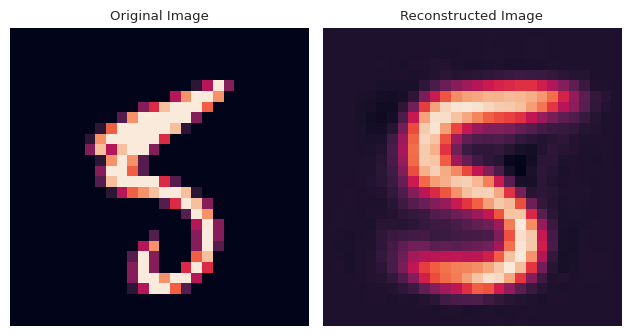

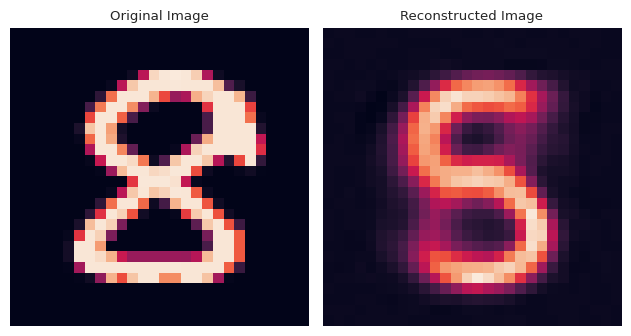

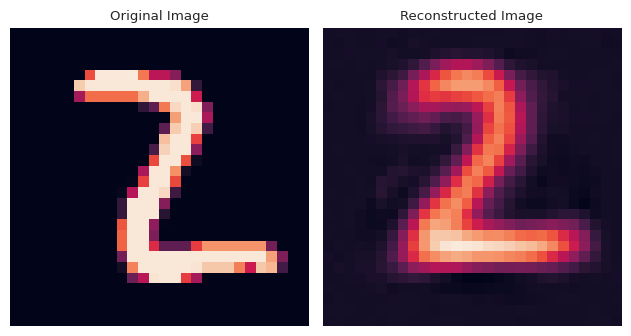

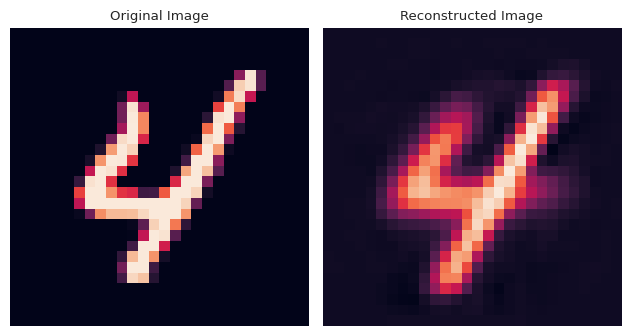

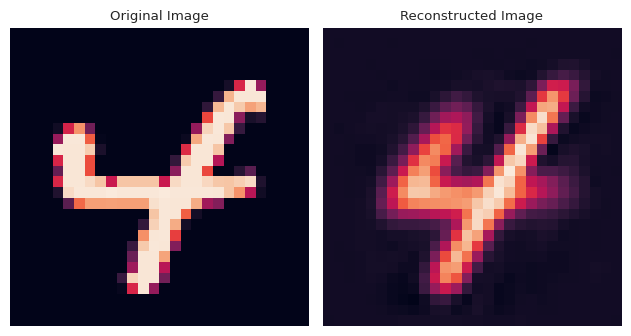

In [16]:
# your code here
for i in range(5):
    plot_digits(X_val_scaled[i], decoder_pred[i])

## Part C

Plot the projections of the digits in the latent space (training and test).

In [17]:
encoder_pred_train = encoder(X_train_scaled)
# Define colors for each category
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']

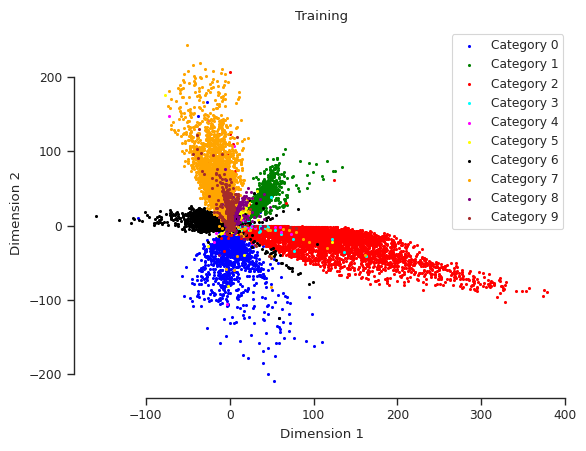

In [18]:
fig, ax = plt.subplots()
for i in range(10):
    ax.scatter(encoder_pred_train[:, 0][y_train == i], encoder_pred_train[:, 1][y_train == i],
                color=colors[i], label=f'Category {i}',s=2)

ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_title("Training")
ax.legend(loc="best")
sns.despine(trim=True)

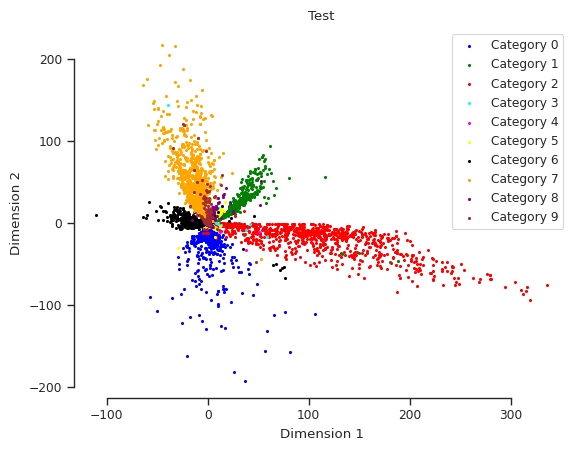

In [19]:
fig, ax = plt.subplots()
for i in range(10):
    ax.scatter(encoder_pred[:, 0][y_val == i], encoder_pred[:, 1][y_val == i],
                color=colors[i], label=f'Category {i}',s=2)

ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_title("Test")
ax.legend(loc="best")
sns.despine(trim=True)

## Part D

Use `scikitlearn` to fit a mixture of Gaussians to the latent space. Use 10 components.
Then sample five times from the fitted mixture of Gaussians, reconstruct the samples, and plot the reconstructed images.

In [20]:
# your code here
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=10, random_state=1234)

gm.fit(encoder_pred)

# Sample 5 times
gm_samples = gm.sample(5)[0]

# Reconstruct Samples
gm_recon = decoder(gm_samples)

In [21]:
def plot_digits_gauss_mix(test_img):
    test_img = test_img.reshape(28,28)
    fig, ax = plt.subplots()

    ax.imshow(test_img)
    ax.set_title("Reconstructed Gaussian Mixture Sample")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

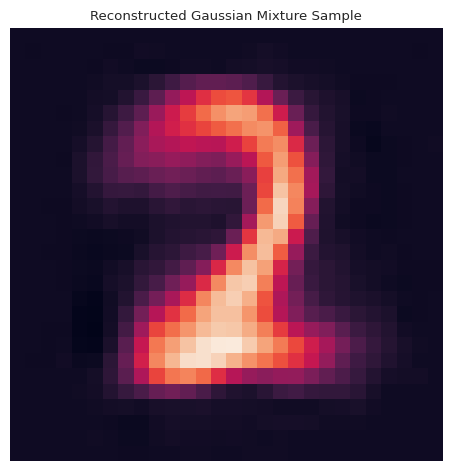

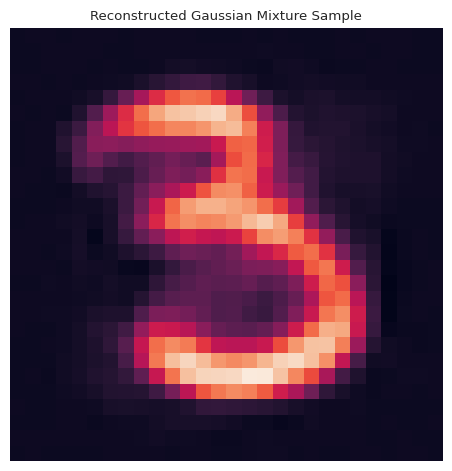

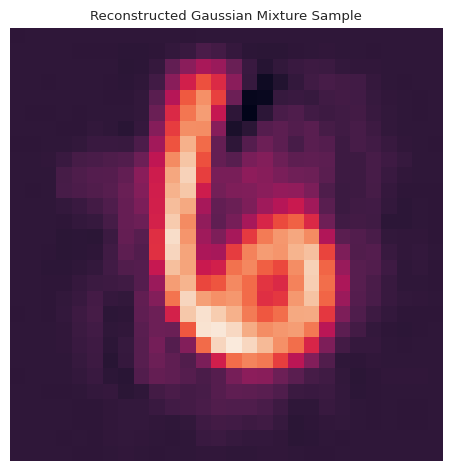

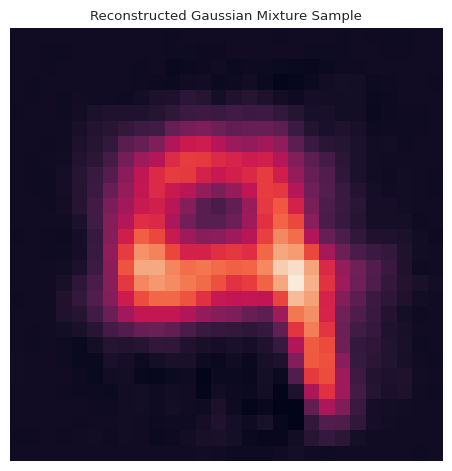

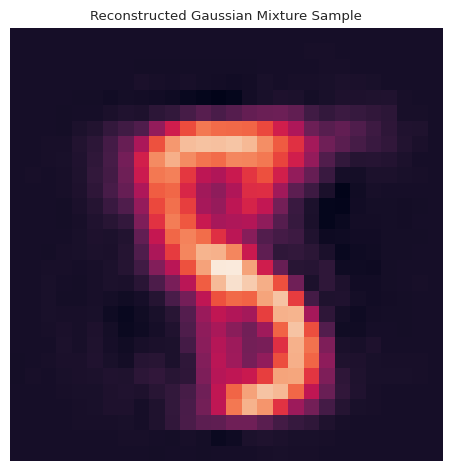

In [22]:
# Plot reconstructed images from gaussian mixture samples
for i in range(5):
    plot_digits_gauss_mix(gm_recon[i])

$\pagebreak$

## Problem 2 - Physics-informed Neural Networks for Solving a Neo-Hookean Hyperelasticity Problem

*The original version of this problem was developed by Atharva Hans as a companion to [this](https://youtu.be/o9JaZGWekWQ).

Consider a neo-Hookean square body defined on $(x,y) \in [0,1]^2$. Let $\mathbf{u}(x,y) = (u_1, u_2)$ describe the displacement field for this body.
This body is subjected to the following displacement boundary conditions:

$$
u_1(0,y) = 0,
$$

$$
u_2(0,y) = 0,
$$

$$
u_1(1,y) = \delta,
$$

$$
u_2(1,y) = 0,
$$

with $\delta$ referring to the applied displacement along the x-direction.

For this hyperelastic material, the stored energy $E_b$ in the body can be expressed in as:

$$
E_b[\mathbf{u}(\cdot)] = \int_{[0,1]^2}\left\{\frac{1}{2}(\sum_{i=1}^2\sum_{j=1}^2{F_{ij}^2} - 2)- \ln(\det(\mathbf{F})) + 50\ln(\det(\mathbf{F}))^2\right\} dxdy,
$$

with

$$
\mathbf{F} = \mathbf{I} + \nabla \mathbf{u},
$$

where $\mathbf{I}$ is an identity matrix.

The final orientation of this body is described by a displacement field that minimizes the stored energy $E_b$.
The idea is to use a neural network to approximate the displacement field and train it by minimizing the stored energy $E_b$.

To automatically satisfy the boundary conditions, we will use this approximation:
$$
u_1(x,y) = \delta - \delta(1-x) + x(1-x)N_1(x,y;\theta),
$$
and,
$$
u_2(x,y) = x(1-x)N_2(x,y;\theta)
$$
where $N_1(x,y;\theta)$ and $N_2(x,y;\theta)$ are neural networks.

## Part A

Solve the problem above for $\delta=0.1$ using a physics-informed neural network (PINN).
Use separate neural networks for $N_1(x,y;\theta)$ and $N_2(x,y;\theta)$.
Start with a multi-layer perceptron with 3 hidden layers, each with 128 units, and tanh activations.
Add a Fourier feature layer at the beginning of the network.
Feel free to change the architecture if you think it is necessary.

Use `equinox` for the neural networks and `optax` for the optimization.
Use a sampling average of 32 collocation points to compute the integral of the stored energy.
Use the Adam optimizer with a learning rate of 0.001 for 1000 iterations to debug.
Feel free to play with the learning rate, the number of collocation points, and the number of iterations.

Show the evolution of the loss function over the iterations.
Plot the final displacement field (plot $u_1(x,y)$ and $u_2(x,y)$ separately).

*Put your answer here. Use as many markdown and code blocks as you want.*

In [23]:
import jax
import equinox as eqx
import jax.random as jrandom
from jax import grad, vmap
import jax.numpy as jnp

class FourierEncoding(eqx.Module):
    B: jax.Array

    @property
    def num_fourier_features(self) -> int:
        return self.B.shape[0]

    @property
    def in_size(self) -> int:
        return self.B.shape[1]

    @property
    def out_size(self) -> int:
        return self.B.shape[0] * 2

    def __init__(self,
                 in_size: int,
                 num_fourier_features: int,
                 key: jax.random.PRNGKey,
                 sigma: float = 1.0):
        self.B = jax.random.normal(
            key, shape=(num_fourier_features, in_size),
            dtype=jax.numpy.float32) * sigma

    def __call__(self, x: jax.Array, **kwargs) -> jax.Array:
        return jax.numpy.concatenate(
            [jax.numpy.cos(jax.numpy.dot(self.B, x)),
             jax.numpy.sin(jax.numpy.dot(self.B, x))],
            axis=0)

In [24]:
# The model that satisfies the boundary conditions
u_hat_1 = lambda x, y, DELTA, model1: DELTA - DELTA * (1.0 - x) + x * (1.0 - x) * model1(jnp.array([x, y]))
u_hat_2 = lambda x, y, model2: x * (1.0 - x) * model2(jnp.array([x, y]))

u_hat_1_x = grad(u_hat_1, 0)
u_hat_1_y = grad(u_hat_1, 1)

u_hat_2_x = grad(u_hat_2, 0)
u_hat_2_y = grad(u_hat_2, 1)

In [25]:
F_matrix = lambda x,y,delta, model1, model2: jnp.array([[1.0 + u_hat_1_x(x, y, delta, model1), u_hat_1_y(x, y, delta, model1)],
                                  [u_hat_2_x(x, y, model2), 1.0 + u_hat_2_y(x, y, model2)]])

pde_residual = vmap(lambda x,y,delta, model1, model2: (0.5 * (jnp.square(F_matrix(x,y,delta, model1, model2)).sum() -2)
                                                  - jnp.log(jnp.linalg.det(F_matrix(x,y,delta, model1, model2)))
                                                  + 50 * jnp.log(jnp.linalg.det(F_matrix(x,y,delta, model1, model2))) ** 2),
                                                  in_axes=(0,0,None, None, None))

pinn_loss = lambda model, x, y, delta:jnp.mean(jnp.square(pde_residual(x,y,delta, model[0], model[1])))

In [26]:
key = jax.random.PRNGKey(0)
key1, key2, key = jax.random.split(key, 3)
num_fourier_features = 100
width_size = 128
depth = 4

model1 = eqx.nn.Sequential([
    eqx.nn.Lambda(
        FourierEncoding(2, num_fourier_features, key1, sigma=6.0)),
    eqx.nn.Lambda(
        eqx.nn.MLP(num_fourier_features * 2, 1, width_size, depth, jnp.tanh, key=key2)),
    eqx.nn.Lambda(
        lambda y: y[0])])

key = jax.random.PRNGKey(1)
key1, key2, key = jax.random.split(key, 3)

model2 = eqx.nn.Sequential([
    eqx.nn.Lambda(
        FourierEncoding(2, num_fourier_features, key1, sigma=6.0)),
    eqx.nn.Lambda(
        eqx.nn.MLP(num_fourier_features * 2, 1, width_size, depth, jnp.tanh, key=key2)),
    eqx.nn.Lambda(
        lambda y: y[0])])

In [27]:
# remember that we need a way to filter out the parameters of the Fourier encoding
import jax.tree_util as jtu
filter_spec1 = jtu.tree_map(lambda _: True, model1)
filter_spec1 = eqx.tree_at(
    lambda tree: (tree[0].fn.B,),
    filter_spec1,
    replace=(False,))

filter_spec2 = jtu.tree_map(lambda _: True, model2)
filter_spec2 = eqx.tree_at(
    lambda tree: (tree[0].fn.B,),
    filter_spec2,
    replace=(False,))

In [28]:
def train_pinn(
        loss,
        model1,model2,
        key,
        optimizer,
        filter_spec1, filter_spec2,
        delta=0.1,
        Lx=1.0,
        Ly=1.0,
        num_collocation_residual=512,
        num_iter=10_000,
        freq=1,
    ):

    fourier_mlp = (model1, model2)

    # this is new
    def new_loss(diff_model, static_model, x, y):
        comb_model = eqx.combine(diff_model, static_model)
        return loss(comb_model, x, y, delta)

    @eqx.filter_jit
    def step(opt_state, model, xs, ys):
        # added this line
        diff_model, static_model = eqx.partition(model, (filter_spec1,filter_spec2))
        # changed the loss to the new loss
        value, grads = eqx.filter_value_and_grad(new_loss)(diff_model, static_model, xs, ys)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value

    opt_state = optimizer.init(eqx.filter(fourier_mlp, eqx.is_inexact_array))

    losses = []
    for i in range(num_iter):
        key1, key2, key = jrandom.split(key, 3)
        xb = jrandom.uniform(key1, (num_collocation_residual,), maxval=Lx)
        yb = jrandom.uniform(key2, (num_collocation_residual,), maxval=Ly)
        fourier_mlp, opt_state, value = step(opt_state, fourier_mlp, xb, yb)
        if value == jnp.nan:
            break
        if i % freq == 0:
            losses.append(value)
            print(f"Step {i}, residual loss {value:.3e}")
    return fourier_mlp, losses

In [29]:
import optax
key, subkey = jax.random.split(key)
optimizer = optax.adam(1e-3)
trained_model, losses = train_pinn(
    pinn_loss, model1, model2, key, optimizer, filter_spec1,filter_spec2,
    num_collocation_residual=32, num_iter=3_000, freq=100, Lx=1.0, Ly=1.0)

Step 0, residual loss 5.791e-01
Step 100, residual loss 1.813e-03
Step 200, residual loss 1.157e-03
Step 300, residual loss 1.018e-03
Step 400, residual loss 1.090e-03
Step 500, residual loss 8.360e-04
Step 600, residual loss 1.043e-03
Step 700, residual loss 9.146e-04
Step 800, residual loss 7.013e-04
Step 900, residual loss 8.261e-04
Step 1000, residual loss 6.707e-04
Step 1100, residual loss 8.486e-04
Step 1200, residual loss 8.004e-04
Step 1300, residual loss 6.926e-04
Step 1400, residual loss 7.586e-04
Step 1500, residual loss 6.430e-04
Step 1600, residual loss 6.776e-04
Step 1700, residual loss 8.205e-04
Step 1800, residual loss 7.684e-04
Step 1900, residual loss 7.462e-04
Step 2000, residual loss 7.244e-04
Step 2100, residual loss 6.195e-04
Step 2200, residual loss 6.527e-04
Step 2300, residual loss 6.963e-04
Step 2400, residual loss 7.065e-04
Step 2500, residual loss 7.935e-04
Step 2600, residual loss 7.235e-04
Step 2700, residual loss 6.627e-04
Step 2800, residual loss 6.074e-

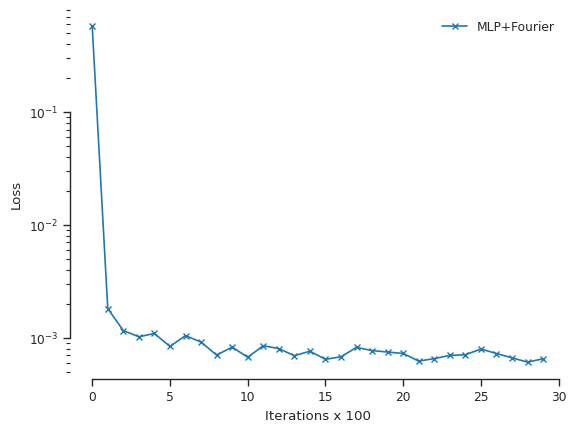

In [30]:
fig, ax = plt.subplots()
ax.plot(losses, '-x', label="MLP+Fourier")
# set log scale for y axis
ax.set_yscale('log')
ax.set_xlabel("Iterations x 100")
ax.set_ylabel("Loss")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

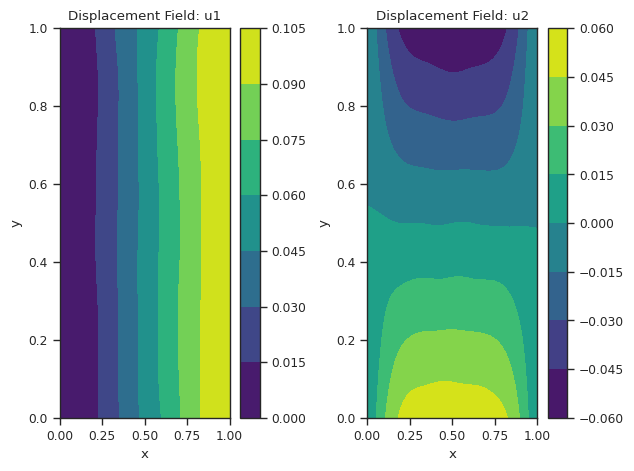

In [31]:
x = jnp.linspace(0, 1, 100)
y = jnp.linspace(0, 1, 100)
X, Y = jnp.meshgrid(x, y)

v_u_hat_1 = vmap(u_hat_1, in_axes=(0, 0, None, None))
u_pred_1 = v_u_hat_1(X.flatten(), Y.flatten(), 0.1, trained_model[0]).reshape(X.shape)

v_u_hat_2 = vmap(u_hat_2, in_axes=(0, 0, None))
u_pred_2 = v_u_hat_2(X.flatten(), Y.flatten(), trained_model[1]).reshape(Y.shape)

plt.subplot(1, 2, 1)
plt.title('Displacement Field: u1')
plt.contourf(x, y, u_pred_1, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.title('Displacement Field: u2')
plt.contourf(x, y, u_pred_2, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

## Part B

Solve the problem for $\delta=0.5$ using the same architecture as above.
It will likely fail to train.
If yes, then use the solution of $\delta=0.1$ as the initial guess for $\delta=0.2$, and then use the solution of $\delta=0.2$ as the initial guess for $\delta=0.3$, and so on, until you reach $\delta=0.5$.
This is called transfer learning.

At the end, plot the final displacement field for $\delta=0.5$.

*Put your answer here. Use as many markdown and code blocks as you want.*

In [32]:
# your code here
# Solve the problem for $\delta=0.5$ using the same architecture as above.
key, subkey = jax.random.split(key)
optimizer = optax.adam(1e-3)
trained_model_B, losses_B = train_pinn(
    pinn_loss, model1, model2, key, optimizer, filter_spec1, filter_spec2,
    num_collocation_residual=32, num_iter=1_500, freq=100, Lx=1.0, Ly=1.0, delta=0.5)

Step 0, residual loss 7.153e+01
Step 100, residual loss 3.521e-01
Step 200, residual loss 2.927e-01
Step 300, residual loss 2.498e-01
Step 400, residual loss 2.461e-01
Step 500, residual loss 2.240e-01
Step 600, residual loss 2.962e-01
Step 700, residual loss 2.140e-01
Step 800, residual loss 2.437e-01
Step 900, residual loss 1.941e-01
Step 1000, residual loss 2.456e-01
Step 1100, residual loss 2.267e-01
Step 1200, residual loss 2.323e-01
Step 1300, residual loss 2.258e-01
Step 1400, residual loss 2.152e-01


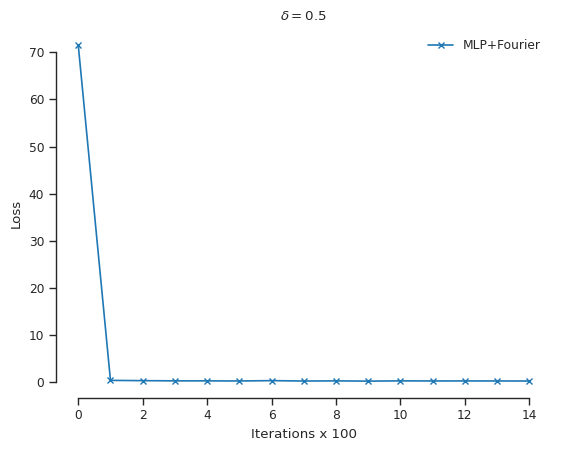

In [33]:
fig, ax = plt.subplots()
ax.plot(losses_B, '-x', label="MLP+Fourier")
# set log scale for y axis
ax.set_title('$\delta = 0.5$')
ax.set_xlabel("Iterations x 100")
ax.set_ylabel("Loss")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

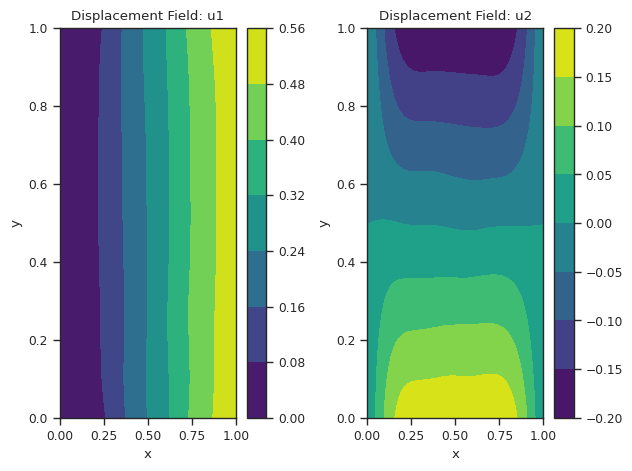

In [34]:
x = jnp.linspace(0, 1, 100)
y = jnp.linspace(0, 1, 100)
X, Y = jnp.meshgrid(x, y)

v_u_hat_1 = vmap(u_hat_1, in_axes=(0, 0, None, None))
u_pred_1 = v_u_hat_1(X.flatten(), Y.flatten(), 0.5, trained_model_B[0]).reshape(X.shape)

v_u_hat_2 = vmap(u_hat_2, in_axes=(0, 0, None))
u_pred_2 = v_u_hat_2(X.flatten(), Y.flatten(), trained_model_B[1]).reshape(Y.shape)

plt.subplot(1, 2, 1)
plt.title('Displacement Field: u1')
plt.contourf(x, y, u_pred_1, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.title('Displacement Field: u2')
plt.contourf(x, y, u_pred_2, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

## Part C

Solve the parametric problem for $\delta \in [0,0.5]$. That is, build a neural network that takes $\delta$ as input and outputs the displacement field. To do this:
+ Modify the loss function to:

$$
\mathcal{L} = \int_0^{0.5} \int_{[0,1]^2} \left\{\frac{1}{2}(\sum_{i}\sum_{j}{F_{ij}^2} - 2)- \ln(\det(\mathbf{F})) + 50\ln(\det(\mathbf{F}))^2\right\} dxdy d\delta.
$$

+ Modify the neural networks to take $\delta$ as input, say $N_1(x,y;\delta;\theta)$ and $N_2(x,y;\delta;\theta)$. Your field will be $\mathbf{u}(x,y;\delta;\theta)$.
Use the following architecture for the neural networks:

$$
N_1(x,y;\delta) = \sum_{i=1}^n b_{1,i}(\delta)t_{1,i}(x,y).
$$

Here, $n$ is your choice (start with $n=10$), $b_{1,i}$ is a neural network that takes $\delta$ as input and outputs a scalar, and $t_{1,i}(x,y)$ is a multi-layer perceptron with 3 hidden layers, each with 128 units, and tanh activations, and Fourier features at the beginning. The same applies to $N_2(x,y;\delta)$. This representation resembles an expansion in terms of basis functions.
The same architecture appears in DeepONet.

Plot the $x$ and $y$ displacement at $x=0.5, y=0.5$ as a function of $\delta$.

In [35]:
class ParametricModel(eqx.Module):
    """This model captures a simple structure made out of branches and trunks."""
    branch: list  # These are the b's
    trunk: list   # These are the phi's

    def __init__(self, branch_width=8, branch_depth=4, m=2, trunk_width=128, trunk_depth=4, trunk_num_fourier_features=100, key1=0, key2=1):
        key1=jax.random.PRNGKey(key1)
        key2=jax.random.PRNGKey(key2)

        self.branch = [eqx.nn.MLP('scalar', 'scalar', branch_width, branch_depth, jax.nn.tanh, key=k) for k in jrandom.split(key1, m)]
        self.trunk = [eqx.nn.Sequential([
            FourierEncoding(2, trunk_num_fourier_features, key=k),
            eqx.nn.MLP(trunk_num_fourier_features * 2, 'scalar', trunk_width, trunk_depth, jax.nn.tanh, key=k)]) for k in jrandom.split(key2, m)]


    def __call__(self, x, y, xi, **kwargs):
        res = 0.0
        for b, t in zip(self.branch, self.trunk):
            res += b(xi) * t(jnp.array([x,y]))
        return res

# The model that satisfies the boundary conditions
u_hat_1 = lambda x, y, DELTA, model1: DELTA - DELTA * (1.0 - x) + x * (1.0 - x) * model1(x, y, DELTA)
u_hat_2 = lambda x, y, DELTA, model2: x * (1.0 - x) * model2(x, y, DELTA)

u_hat_1_x = grad(u_hat_1, 0)
u_hat_1_y = grad(u_hat_1, 1)

u_hat_2_x = grad(u_hat_2, 0)
u_hat_2_y = grad(u_hat_2, 1)

In [36]:
M = 3
model1 = ParametricModel(key1=1234, key2=5678, m=M)
model2 = ParametricModel(key1=3241, key2=3465, m=M)

In [37]:
# remember that we need a way to filter out the parameters of the Fourier encoding
import jax.tree_util as jtu

filter_spec1 = jtu.tree_map(lambda _: True, model1)
for l in range(M):
    filter_spec1 = eqx.tree_at(
        lambda tree: (tree.trunk[l].layers[0].B,),
        filter_spec1,
        replace=(False,))

filter_spec2 = jtu.tree_map(lambda _: True, model2)
for l in range(M):
    filter_spec2 = eqx.tree_at(
        lambda tree: (tree.trunk[l].layers[0].B,),
        filter_spec2,
        replace=(False,))

In [38]:
F_matrix = lambda x,y,delta, model1, model2: jnp.array([[1.0 + u_hat_1_x(x, y, delta, model1), u_hat_1_y(x, y, delta, model1)],
                                  [u_hat_2_x(x, y, delta, model2), 1.0 + u_hat_2_y(x, y, delta, model2)]])

pde_residual = vmap(lambda x,y,delta, model1, model2: (0.5 * (jnp.square(F_matrix(x,y,delta, model1, model2)).sum() -2)
                                                  - jnp.log(jnp.linalg.det(F_matrix(x,y,delta, model1, model2)))
                                                  + 50 * jnp.log(jnp.linalg.det(F_matrix(x,y,delta, model1, model2))) ** 2),
                                                  in_axes=(0,0,0, None, None))

pinn_loss = lambda model, x, y, delta:jnp.mean(jnp.square(pde_residual(x,y,delta, model[0], model[1])))

In [39]:
def train_pinn(
        loss,
        model1,model2,
        key,
        optimizer,
        filter_spec1, filter_spec2,
        Lx=1.0,
        Ly=1.0,
        num_collocation_residual=512,
        num_xis = 16,
        num_iter=10_000,
        freq=1,
    ):

    fourier_mlp = (model1, model2)

    # this is new
    def new_loss(diff_model, static_model, x, y, xis):
        comb_model = eqx.combine(diff_model, static_model)
        return loss(comb_model, x, y, xis)

    @eqx.filter_jit
    def step(opt_state, model, xs, ys, xis):
        # added this line
        diff_model, static_model = eqx.partition(model, (filter_spec1,filter_spec2))
        # changed the loss to the new loss
        value, grads = eqx.filter_value_and_grad(new_loss)(diff_model, static_model, xs, ys, xis)
        updates, opt_state = optimizer.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, value

    opt_state = optimizer.init(eqx.filter(fourier_mlp, eqx.is_inexact_array))

    losses = []
    for i in range(num_iter):
        key1, key2, key3, key = jrandom.split(key, 4)
        xb = jrandom.uniform(key1, (num_collocation_residual,), maxval=Lx)
        yb = jrandom.uniform(key2, (num_collocation_residual,), maxval=Ly)
        xis = jrandom.uniform(key3, (num_xis,))
        fourier_mlp, opt_state, value = step(opt_state, fourier_mlp, xb, yb, xis)
        if value == jnp.nan:
            break
        if i % freq == 0:
            losses.append(value)
            print(f"Step {i}, residual loss {value:.3e}")
    return fourier_mlp, losses

In [40]:
import optax
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
optimizer = optax.adam(1e-3)
trained_model, losses = train_pinn(
    pinn_loss, model1, model2, key, optimizer, filter_spec1,filter_spec2,
    num_collocation_residual=32, num_iter=2_000, freq=100, Lx=1.0, Ly=1.0, num_xis=32)

Step 0, residual loss 1.207e+02
Step 100, residual loss 2.193e+00
Step 200, residual loss 8.095e-01
Step 300, residual loss 8.068e-01
Step 400, residual loss 1.260e+00
Step 500, residual loss 8.753e-01
Step 600, residual loss 6.760e-01
Step 700, residual loss 8.769e-01
Step 800, residual loss 5.692e-01
Step 900, residual loss 7.803e-01
Step 1000, residual loss 6.885e-01
Step 1100, residual loss 4.386e-01
Step 1200, residual loss 6.007e-01
Step 1300, residual loss 6.360e-01
Step 1400, residual loss 5.216e-01
Step 1500, residual loss 8.570e-01
Step 1600, residual loss 2.847e-01
Step 1700, residual loss 8.022e-01
Step 1800, residual loss 6.891e-01
Step 1900, residual loss 4.202e-01


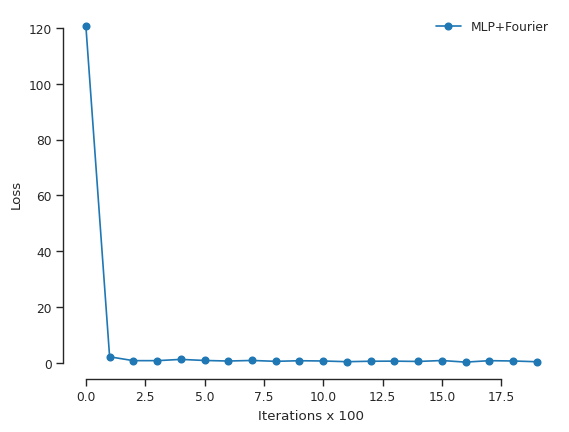

In [41]:
fig, ax = plt.subplots()
ax.plot(losses, '-o', label="MLP+Fourier")
# set log scale for y axis
ax.set_xlabel("Iterations x 100")
ax.set_ylabel("Loss")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

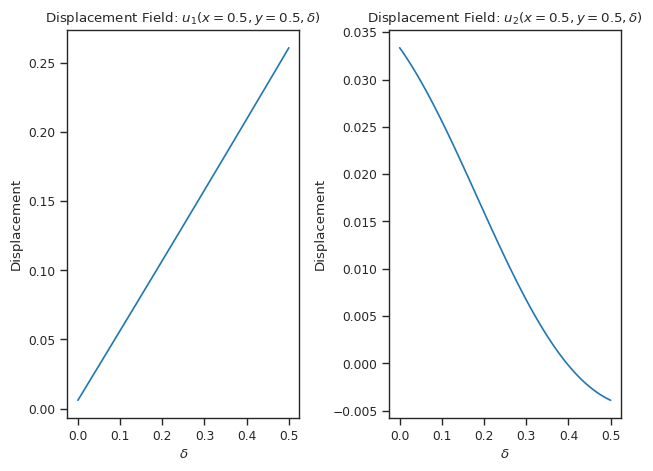

In [42]:
x = 0.5
y = 0.5
delta = np.linspace(0,0.5,100)

v_u_hat_1 = vmap(u_hat_1, in_axes=(None, None, 0, None))
u_pred_1 = v_u_hat_1(x, y, delta, trained_model[0])

v_u_hat_2 = vmap(u_hat_2, in_axes=(None, None, 0, None))
u_pred_2 = v_u_hat_2(x, y, delta, trained_model[1])

plt.subplot(1, 2, 1)
plt.title('Displacement Field: $u_{1}(x=0.5,y=0.5,\delta)$')
plt.plot(delta, u_pred_1)
plt.xlabel('$\delta$')
plt.ylabel('Displacement')

plt.subplot(1, 2, 2)
plt.title('Displacement Field: $u_{2}(x=0.5,y=0.5,\delta)$')
plt.plot(delta, u_pred_2)
plt.xlabel('$\delta$')
plt.ylabel('Displacement')

plt.tight_layout()
plt.show()